In [1]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [2]:
from dataset_creation import dataset_creator as data_generator
from feature_extract import turntake_extractor as feat_extractor
import constants

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


In [3]:
# TEST Variables
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean = False
from_store= True
filter_missing_data=True
transform_features=False
indiv_missing_data=['1_018_35', '2_006_15', '2_006_33', '2_011_29', '2_036_35', '2_044_8', '2_044_30', '3_004_37', '3_007_11', '3_052_27', '3_052_28', '3_058_25', '3_060_1', '3_068_15']
group_missing_data=['1_018', '2_006', '2_006', '2_011', '2_036', '2_044', '2_044', '3_004', '3_007', '3_052', '3_052', '3_058', '3_060', '3_068']

manifest="indiv"
if manifest == "indiv":
    features = ["conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.indiv_tt_X_path
    missing_data=indiv_missing_data
else:
    features = ["var_#turn", "var_dturn", "conv_eq", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.group_tt_X_path
    missing_data=group_missing_data

In [4]:
# Annotation Reader
reliable_ids, reliable_convqs, reliable_kappas = data_generator.get_annotation_realiable_labels(agreeability_thresh, manifest, annotators, zero_mean)
print("Total Groups in Analysis - " + str(len(reliable_ids)))

ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False
Total Groups in Analysis - 273


In [5]:
# Get Turn-Taking feaures for IDs (group/ indiv)
if from_store:
    tt_X = pd.read_csv(store_file, sep=',', header=None).values
#     tt_X.columns = features
#     tt_X.set_index(reliable_ids)
else:
    tt_X = feat_extractor.get_tt_dataset_feats_for(reliable_ids, features, manifest)

In [6]:
# Save Features
if not from_store:
    # Save Dataset -- tt_X
    np.savetxt(store_file, tt_X, delimiter=",")

In [7]:
# Transform Features
if transform_features:
    from sklearn.preprocessing import StandardScaler
    tt_X = StandardScaler().fit_transform(tt_X)
    reliable_convqs = StandardScaler().fit_transform(np.array(reliable_convqs).reshape(-1, 1))

In [8]:
#Dataset Prep
tt_X = pd.DataFrame(data=tt_X, index=reliable_ids, columns=features) 
tt_X["convq"] = reliable_convqs

In [9]:
#Filter Dataset - Remove Incompelete Data
print("Before Filter: Feature Set -> " + str(tt_X.shape))
if filter_missing_data:
    final_reliable_ids = [x for x in reliable_ids if x not in missing_data]
    tt_X = tt_X[tt_X.index.isin(final_reliable_ids)]
print("After Filter: Feature Set -> " + str(tt_X.shape))

Before Filter: Feature Set -> (273, 11)
After Filter: Feature Set -> (259, 11)


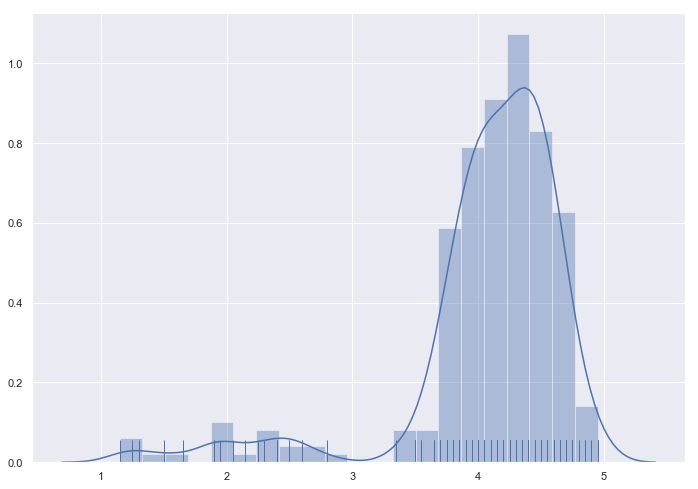

In [10]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

In [11]:
# Statistical Tests:(Main Question)
# Do Turn-Taking features have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# TT Features can be categorised into three categories -> Equality, Fluency and Synchronisation
#
# (Sub Question)
# Does Conversation Equality have a significant effect on the Perceived Individual's Experience of Conversation Quality?
#  1. Use Features "#turns", "%talk", "mean_turn". 
#
# (Sub Question)
# Does Conversation Fluency have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%silence", "mean_silence", "#bc". 
# 
# (Sub Question)
# Does Conversation Synchronisation have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%overlap", "#suc_interupt", "#un_interupt". 
# 
# For all above questions, after (1), perform below steps,
#  2. Fit a Quantile Least Square Regression model on the features vs the convq score.
#  3. Analyse p-value significance @ p<0.05
#  4. Check the co-efficients for informations.

In [19]:
test_feats=["const", "conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]

conv_eq_feats=["const", "conv_eq"]
conv_fl_feats=["const", "%silence", "#bc"]
conv_sy_feats=["const", "%overlap", "#suc_interupt", "#un_interupt"]

full_test_feats=["const", "conv_eq", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]

test_feats=test_feats

In [20]:
# Experiment Below

# Ordinary Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

X = sm.add_constant(tt_X)

model = sm.OLS(X["convq"], X.loc[:,full_test_feats])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  convq   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     5.666
Date:                Sun, 17 May 2020   Prob (F-statistic):           1.53e-05
Time:                        14:44:01   Log-Likelihood:                -246.21
No. Observations:                 259   AIC:                             506.4
Df Residuals:                     252   BIC:                             531.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.6326      0.212     21.863

In [27]:
# Quantile Regression
X = sm.add_constant(tt_X)

model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,full_test_feats])
results = model.fit(q=.5)
print(results.summary())

# model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_fl_feats])
# results = model.fit(q=.4)
# print(results.summary())

# model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_sy_feats])
# results = model.fit(q=.4)
# print(results.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.08168
Model:                       QuantReg   Bandwidth:                      0.2694
Method:                 Least Squares   Sparsity:                       0.8791
Date:                Sun, 17 May 2020   No. Observations:                  259
Time:                        14:50:38   Df Residuals:                      252
                                        Df Model:                            6
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.5753      0.147     31.177      0.000       4.286       4.864
conv_eq           0.0989      0.066      1.489      0.138      -0.032       0.230
%silence         -0.4764      0.200     -2.378      0.018      -0.871      -0.082
#bc               0.0208      0.023  

In [22]:
# Generalised Linear Regression
X = sm.add_constant(tt_X)

model = sm.GLM(X["convq"], X.loc[:,full_test_feats])
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  convq   No. Observations:                  259
Model:                            GLM   Df Residuals:                      252
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                         0.40282
Method:                          IRLS   Log-Likelihood:                -246.21
Date:                Sun, 17 May 2020   Deviance:                       101.51
Time:                        14:44:01   Pearson chi2:                     102.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.6326      0.212     21.863

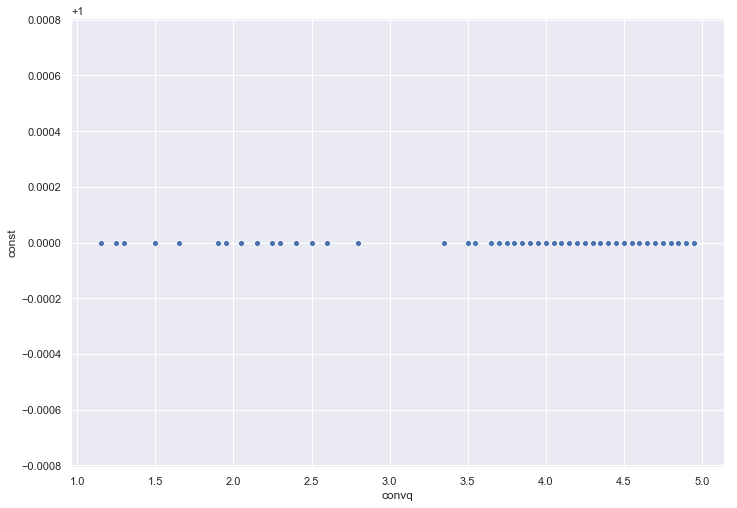

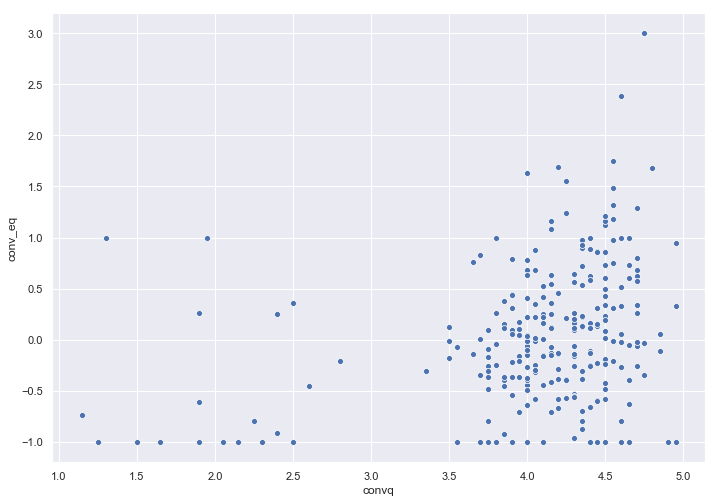

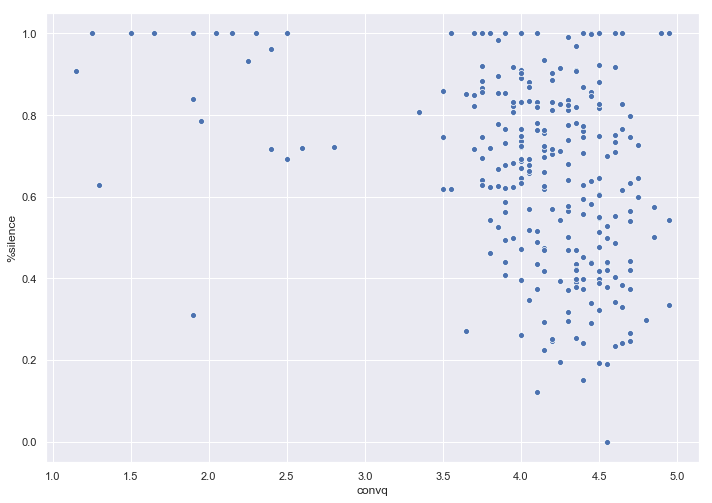

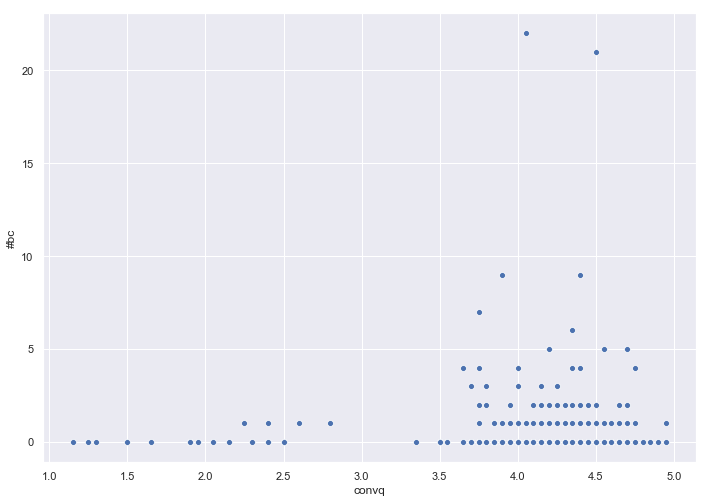

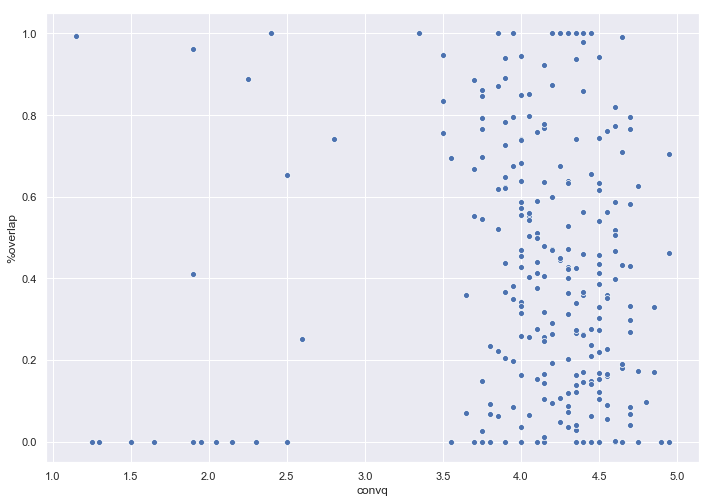

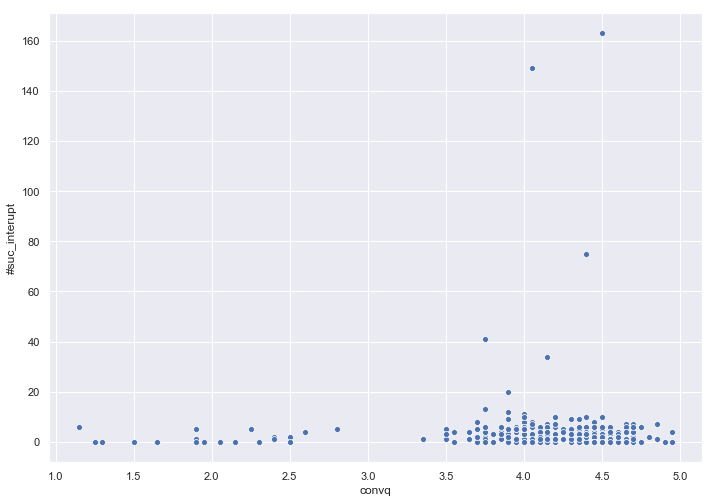

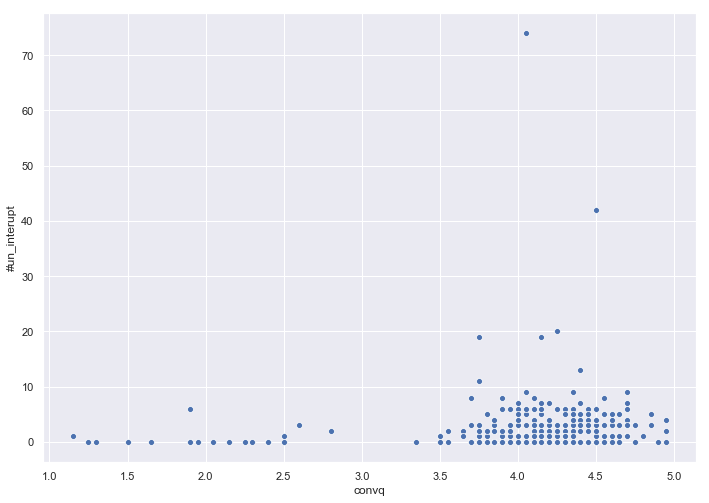

In [23]:
for curr_feat in full_test_feats:
    if curr_feat != "convq":
        sns.scatterplot(x="convq", y=curr_feat, data=X)
        plt.show()